# Reconstruction from interpolated values with known locations

This notebook illustrates reconstruction using a simple forward model: the interpolation of a volume at a number of points on or off the grid, inside or outside of the range of the grid (to check that the interpolation wraps around). 

The inverse problem is solved using GD and CG.

In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
import numpy as np
from matplotlib import pyplot as plt
from simplecryoem.interpolate import interpolate
from simplecryoem.algorithm import conjugate_gradient
from simplecryoem.utils import mip_z

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)

### Create the grids and the volume

In [3]:
nx = 5

x_freq = jnp.fft.fftfreq(nx, 1 / nx)
X, Y, Z = jnp.meshgrid(x_freq, x_freq, x_freq)

x_grid = np.array([x_freq[1], len(x_freq)])

vol = (
    jnp.array(np.random.randn(nx, nx, nx))
    + jnp.array(np.random.randn(nx, nx, nx)) * 1j
    + 100
    + 80j
)

all_coords = jnp.array([X.ravel(), Y.ravel(), Z.ravel()])

### Points to interpolate at

In [4]:
N = 2000

# The points will be between low and high.

# Within the Fourier grid range
# low = -nx/2
# high = nx/2 + 1

# Going outside the range by half, to ensure wrap-around works well.
low = -3 * nx
high = 3 * nx

# On the grid
# pts = jnp.array(np.random.randint(low, high, size = (3,N))).astype(jnp.float64)

# And off the grid
pts = 3 * nx * np.random.randn(3, N)

# Print the points
print(f"min(pts) = {jnp.min(pts)}")
print(f"max(pts) = {jnp.max(pts)}")
print(f"x_freq = {x_freq}")

min(pts) = -48.53004725631163
max(pts) = 56.8068078156043
x_freq = [ 0.  1.  2. -2. -1.]


### The forward model: interpolation

In [5]:
@jax.jit
def interpolate_fun(vol):
    return interpolate(pts, x_grid, vol, "tri")

### The interpolated values, i.e. the data. 

When the points above are on the grid, this is the volume.

In [6]:
data = interpolate_fun(vol)

In [7]:
@jax.jit
def loss_fun(v):
    err = interpolate_fun(v) - data
    return 1 / (2 * len(data)) * jnp.sum(jnp.real(jnp.conj(err) * err))


@jax.jit
def loss_fun_grad(v):
    return jax.grad(loss_fun)(v)

In [8]:
print(loss_fun(vol))
print(loss_fun_grad(vol).shape)

0.0
(5, 5, 5)


### Solve the inverse problem

#### SGD

In [9]:
v0 = (
    jnp.array(np.random.randn(nx, nx, nx)) + jnp.array(np.random.randn(nx, nx, nx)) * 1j
)
# v0 = vol + 0.1*np.random.randn(nx,nx,nx)

vk = v0
N_iter = 2000
alpha = 100
for k in range(N_iter):
    vk = vk - alpha * jnp.conj(loss_fun_grad(vk))

    if jnp.mod(k, 100) == 0:
        loss = loss_fun(vk)
        print("iter ", k, ", loss = ", loss)

err = jnp.max(jnp.abs(vk - vol))
print("err =", err)

iter  0 , loss =  324.79726615603744
iter  100 , loss =  5.9328148901074534e-05
iter  200 , loss =  2.732905789491332e-08
iter  300 , loss =  1.3654624606123505e-11
iter  400 , loss =  6.975046327453924e-15
iter  500 , loss =  3.59658102686485e-18
iter  600 , loss =  1.8632134015404244e-21
iter  700 , loss =  9.676832778520723e-25
iter  800 , loss =  1.0310980011090384e-27
iter  900 , loss =  7.94515460189636e-28
iter  1000 , loss =  7.94515460189636e-28
iter  1100 , loss =  7.94515460189636e-28
iter  1200 , loss =  7.94515460189636e-28
iter  1300 , loss =  7.94515460189636e-28
iter  1400 , loss =  7.94515460189636e-28
iter  1500 , loss =  7.94515460189636e-28
iter  1600 , loss =  7.94515460189636e-28
iter  1700 , loss =  7.94515460189636e-28
iter  1800 , loss =  7.94515460189636e-28
iter  1900 , loss =  7.94515460189636e-28
err = 4.024457853832443e-13


(5, 5, 5)


Text(0.5, 1.0, 'Entry-wise error -- gradient descent')

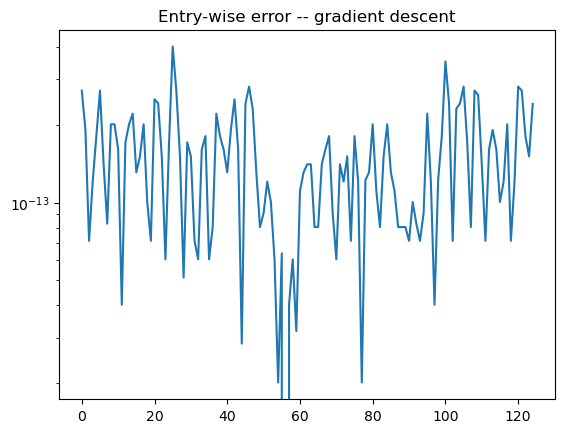

In [10]:
print(vk.shape)
err = vk - vol
plt.semilogy(jnp.abs(err).reshape(-1))
plt.title("Entry-wise error -- gradient descent")

Text(0.5, 1.0, 'Maximum intensity projection of the error')

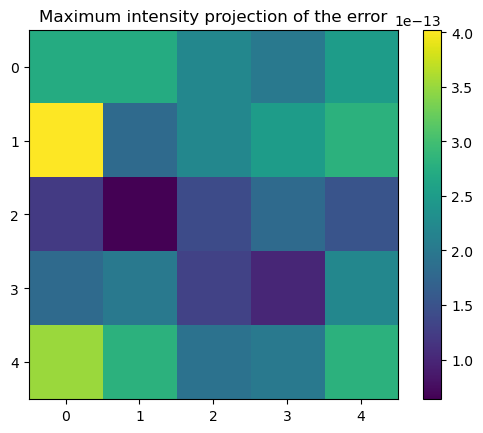

In [11]:
mip_z(jnp.abs(vk - vol))
plt.colorbar()
plt.title("Maximum intensity projection of the error")

#### CG

In [12]:
v0 = (
    jnp.array(np.random.randn(nx, nx, nx)) + jnp.array(np.random.randn(nx, nx, nx)) * 1j
)
zero = jnp.zeros(vol.shape) * 1j
Ab = -jnp.conj(loss_fun_grad(zero))
AA = lambda a: jnp.conj(loss_fun_grad(a)) + Ab

vcg, max_iter, _ = conjugate_gradient(AA, Ab, v0, 50, verbose=True)
err = jnp.max(jnp.abs(vcg - vol))
print("err =", err)

  cg iter 0 ||r|| = 0.7491111239616406
  cg iter 10 ||r|| = 0.0017717714940915985
  cg iter 20 ||r|| = 1.1953975336378236e-05
  cg iter 30 ||r|| = 6.280004191906208e-08
  cg iter 40 ||r|| = 2.5373372412584826e-10
err = 3.887667496794853e-09


Text(0.5, 1.0, 'MIP of the error -- CG')

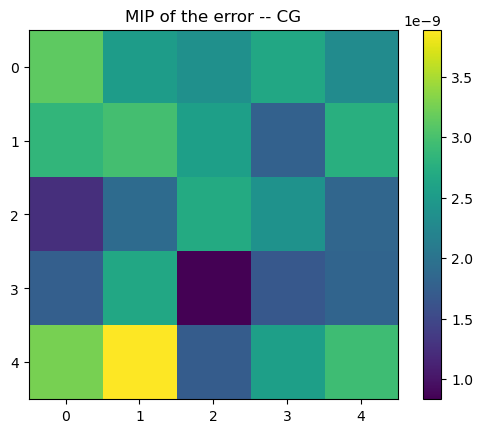

In [13]:
mip_z(jnp.abs(vcg - vol))
plt.colorbar()
plt.title("MIP of the error -- CG")